# Gaussian mixure variational autoencoder

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import os, sys
import cv2
import glob

# os.chdir(os.path.dirname(os.getcwd()))
#CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append('Alg_GMVAE/') # Consider also the parent directory for the module lookup

from utils.dataset import Dataset
from bunch import Bunch
from utils.args_processing import get_args, get_config_and_flags
from utils.logger import Logger
from utils.utils import save_img

import matplotlib.pyplot as plt
import numpy as np
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import utils.utils as utils
import utils.constants as const 
plt.close("all")

#from GMVAE_model import GMVAE_model

Using TensorFlow backend.


In [2]:
# create the experiments dirs
summary_dir = 'logdir/'
checkpoint_dir = 'modeldir/'
results_dir = 'results/'
utils.create_dirs([summary_dir, checkpoint_dir, results_dir])

0

## Dataset

In [3]:
def normalize_data(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (img.astype(np.float32) - 127.5) / 127.5

# load tomato images
def load_real_samples():
    # folder where data is placed
    BASE_FOLDER = '/floyd/input/tomato_dataset/training'
    
    trainAug = ImageDataGenerator(
            rescale=1 / 255.0,
            rotation_range=20,
            zoom_range=0.05,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="nearest",
            validation_split=0.2)
            #preprocessing_function=normalize_data)
    
    trainGen = trainAug.flow_from_directory(
            BASE_FOLDER,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=True,
            batch_size=32,
            subset='training')
    
    valGen = trainAug.flow_from_directory(
            BASE_FOLDER,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=True,
            batch_size=32,
            subset='validation')
    
    return trainGen, valGen

In [10]:
def get_coordinates(filename):
  filename_without_format = filename[:-4]
  filename_list = filename_without_format.split('_')
  coordinates_list = filename_list[-1].split('x')
  for item in range(len(coordinates_list)):
    coordinates_list[item] = int(coordinates_list[item])
  return coordinates_list

def load_test_data():
    # folder where data is placed
    BASE_FOLDER = '/floyd/input/tomato_dataset/testing/2019-09-19_06_47_32/'
    img_list = glob.glob(BASE_FOLDER + '*.png')
    images = list()
    coordinates = list()
    
    for img_path in img_list:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_NEAREST)
        #img = (img.astype(np.float32) - 127.5) / 127.5
        img = img / 255
        images.append(img)
        position = get_coordinates(img_path)
        coordinates.append(position)
        
    print('Found ' + str(len(images)) + ' images for test.')
    return (np.asarray(images), coordinates)

In [5]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # get batch
    X, _ = dataset.next()
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [6]:
# select real samples
def generate_test_samples(X, n_samples):
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [11]:
# load image data
dataset, val_dataset = load_real_samples()
test_dataset, test_coordinates = load_test_data()

Found 153360 images belonging to 240 classes.
Found 38160 images belonging to 240 classes.
Found 798 images for test.


## Model

In [15]:
network_params = Bunch()
network_params.input_height = 48
network_params.input_width = 48
network_params.input_nchannels = 3

network_params.hidden_dim =  64
network_params.z_dim =  8
network_params.w_dim =  2
network_params.K =  8
network_params.num_layers =  2

In [16]:
from GMVAE_model import GMVAEModel
vae_model = GMVAEModel(network_params,sigma=0.001, sigma_act=utils.softplus_bias,
                       transfer_fct=tf.nn.relu,learning_rate=2e-4,
                       kinit=tf.contrib.layers.xavier_initializer(),
                       batch_size=32, drop_rate=0.3, 
                       epochs=20, checkpoint_dir=checkpoint_dir, 
                       summary_dir=summary_dir, result_dir=results_dir, 
                       restore=1, model_type=3)
print('\nNumber of trainable paramters', vae_model.trainable_count)


[*] Defining Q(z|x)...
[*] Layer ( Qz_x/conv_1/Relu:0 ) output shape: [32, 24, 24, 32]
[*] Layer ( Qz_x/conv_2/Relu:0 ) output shape: [32, 12, 12, 64]
[*] Layer ( Qz_x/conv_3/Relu:0 ) output shape: [32, 6, 6, 64]

[*] Layer ( Qz_x/dense_1/Relu:0 ) output shape: [32, 16]

[*] Layer ( Qz_x/mean/dense_1/BiasAdd:0 ) output shape: [32, 8]

[*] Layer ( Qz_x/var/dense_1/Softplus:0 ) output shape: [32, 8]

[*] Reparameterization trick...

[*] Defining Q(w|x)...
[*] Layer ( Qw_x/conv_1/Relu:0 ) output shape: [32, 24, 24, 32]
[*] Layer ( Qw_x/conv_2/Relu:0 ) output shape: [32, 12, 12, 64]
[*] Layer ( Qw_x/conv_3/Relu:0 ) output shape: [32, 6, 6, 64]

[*] Layer ( Qw_x/dense_1/Relu:0 ) output shape: [32, 4]

[*] Layer ( Qw_x/mean/dense_1/BiasAdd:0 ) output shape: [32, 2]

[*] Layer ( Qw_x/var/dense_1/Softplus:0 ) output shape: [32, 2]

[*] Reparameterization trick...

[*] Defining P(y|w,z)...

[*] Layer ( Py_wz/dense_1/Relu:0 ) output shape: [32, 64]
[*] Layer ( Py_wz/dense_1_dropout/Identity:0 )

## Train

In [17]:
vae_model.train(dataset, val_dataset, enable_es=1)

Model does NOT exist
Initizalizing Variables ...
EPOCH:  0

TRAIN | Loss: 67241.41 | Recons: 67182.65 | CP: 56.822083 | KL_w: 0.077418655 | KL_y: 1.861645 | L2_loss: 633.5318
VALID | Loss: 67196.76 | Recons: 67143.36 | CP: 52.219185 | KL_w: 0.071807526 | KL_y: 1.1059451 | L2_loss: 751.62823
Saving model...
Model saved
EPOCH:  1

TRAIN | Loss: 51684.97 | Recons: 51635.574 | CP: 48.432228 | KL_w: 0.035082094 | KL_y: 0.9247794 | L2_loss: 723.5993
VALID | Loss: 66177.945 | Recons: 66126.516 | CP: 50.08482 | KL_w: 0.009022563 | KL_y: 1.3324543 | L2_loss: 707.2522
Saving model...
Model saved
EPOCH:  2

TRAIN | Loss: 50657.758 | Recons: 50610.953 | CP: 45.71394 | KL_w: 0.002391073 | KL_y: 1.088097 | L2_loss: 705.3204
VALID | Loss: 65577.586 | Recons: 65529.0 | CP: 47.295055 | KL_w: 0.00023341831 | KL_y: 1.2959245 | L2_loss: 707.2538
Saving model...
Model saved
EPOCH:  3

TRAIN | Loss: 50112.773 | Recons: 50066.92 | CP: 44.68435 | KL_w: 9.270083e-05 | KL_y: 1.165521 | L2_loss: 716.6831
VALID |

## Evaluation

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21


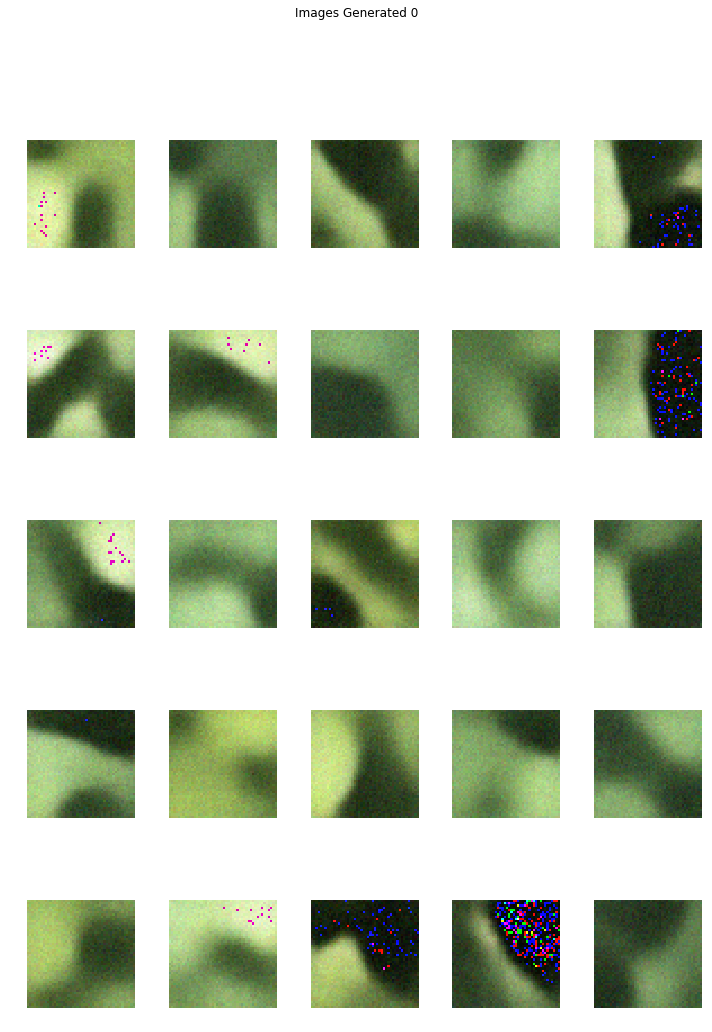

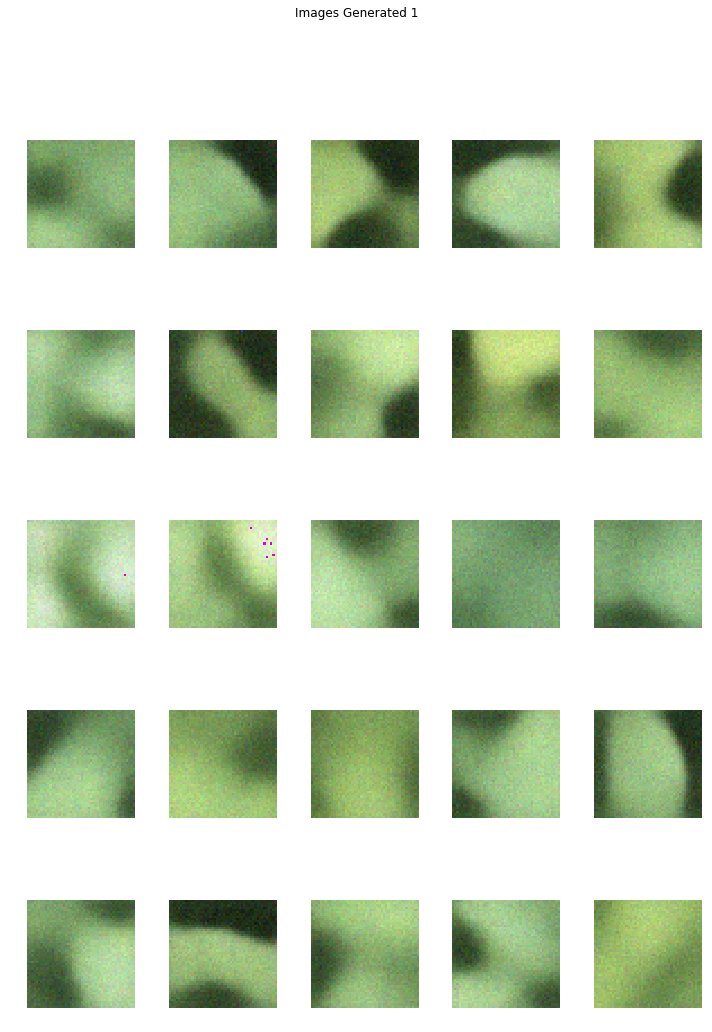

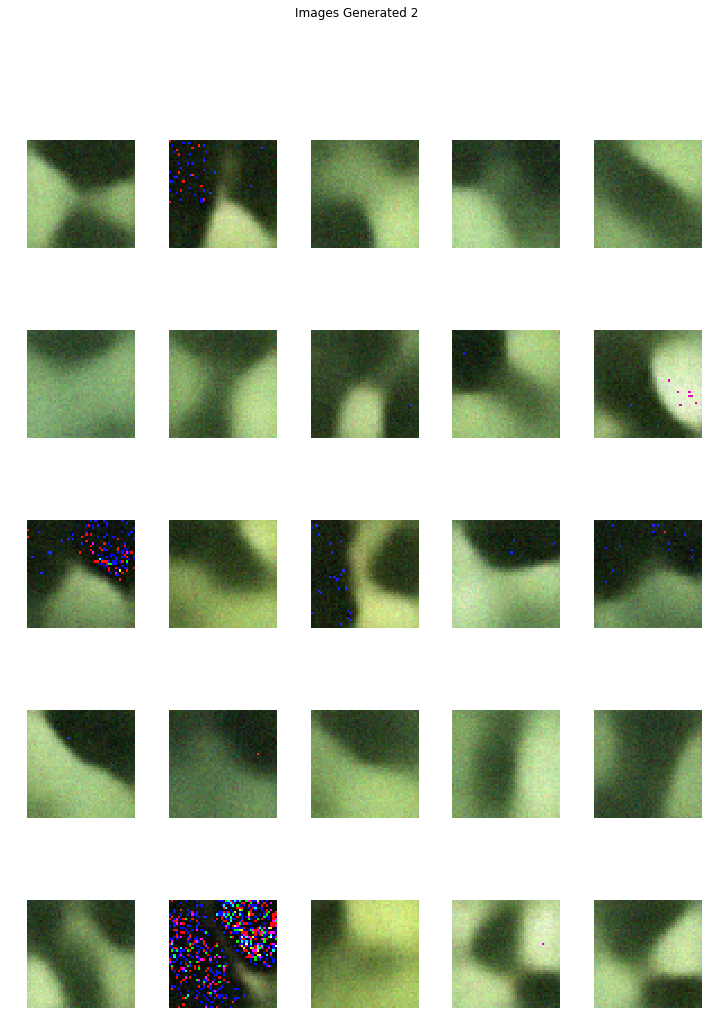

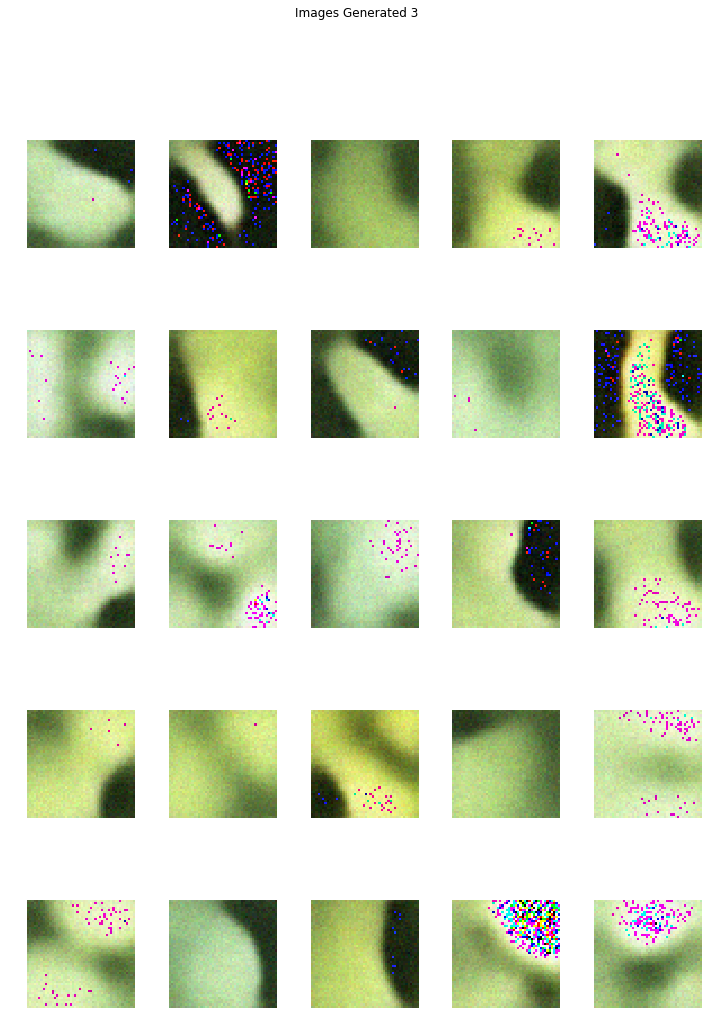

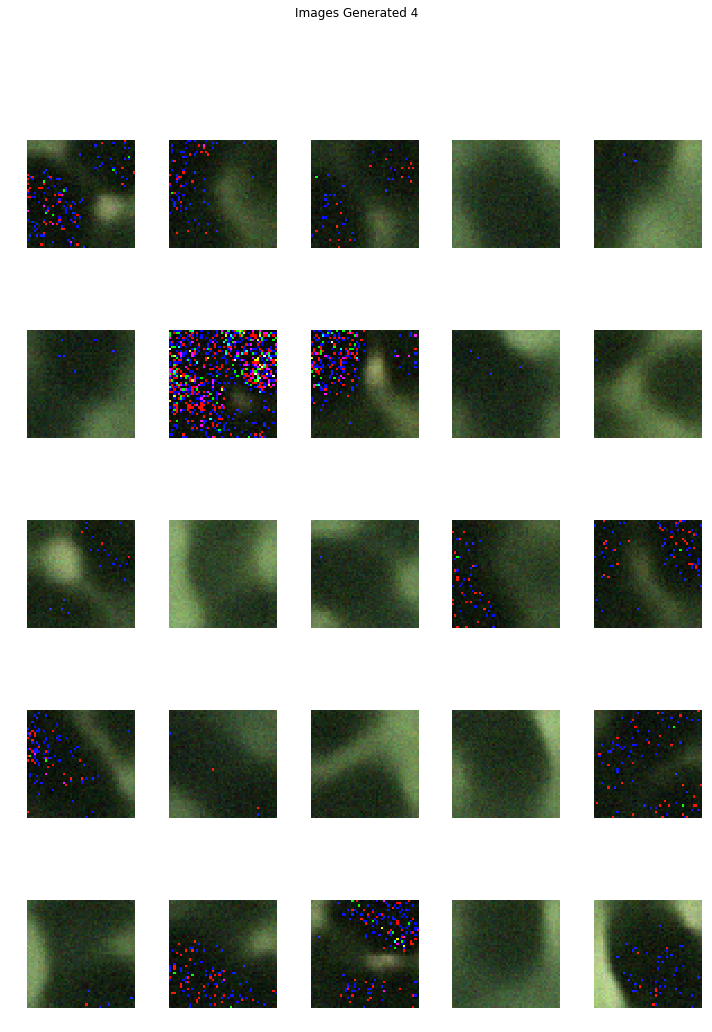

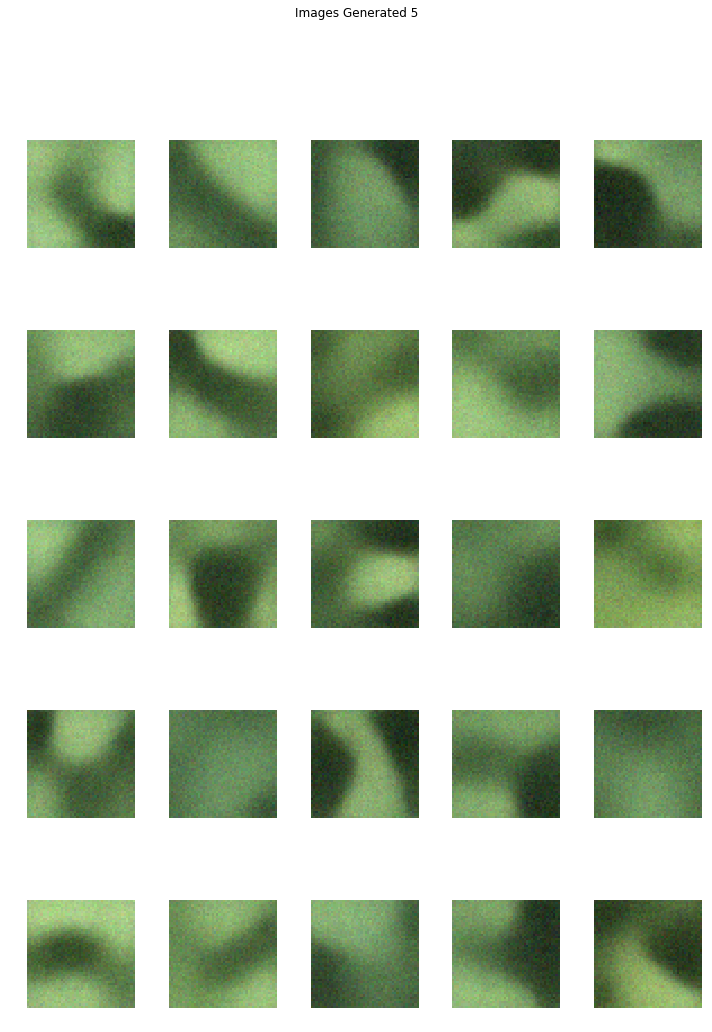

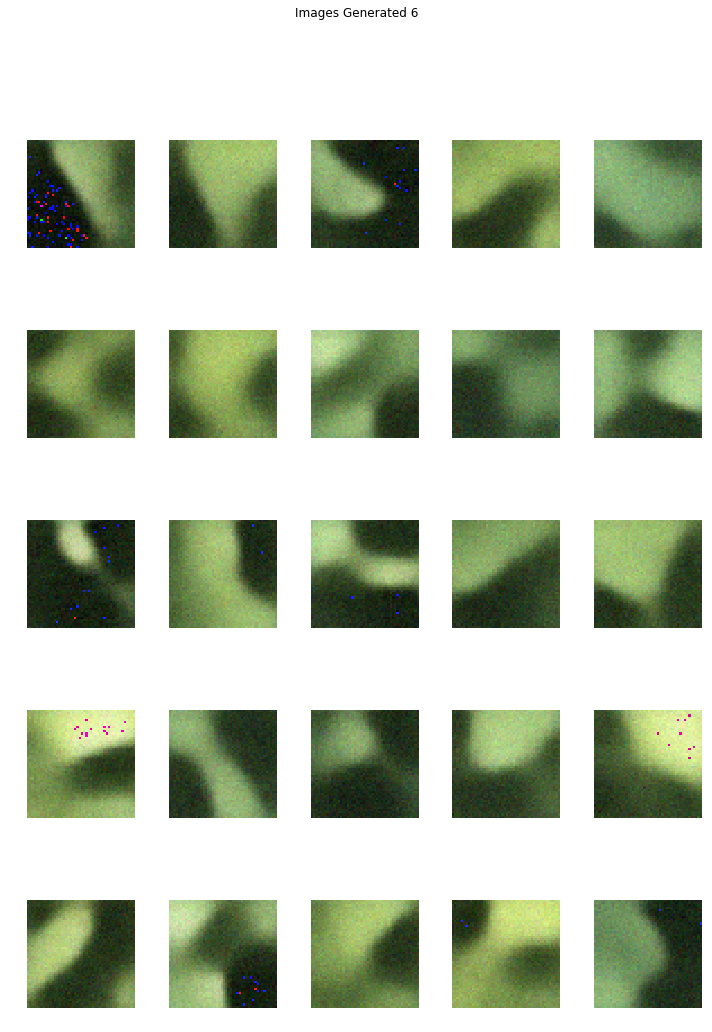

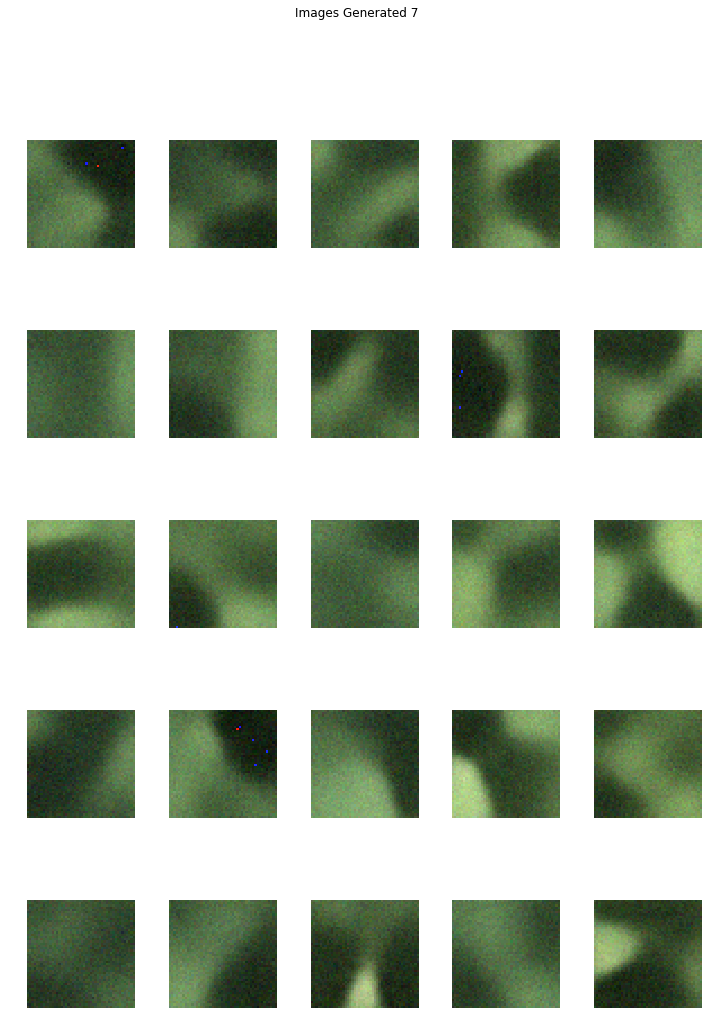

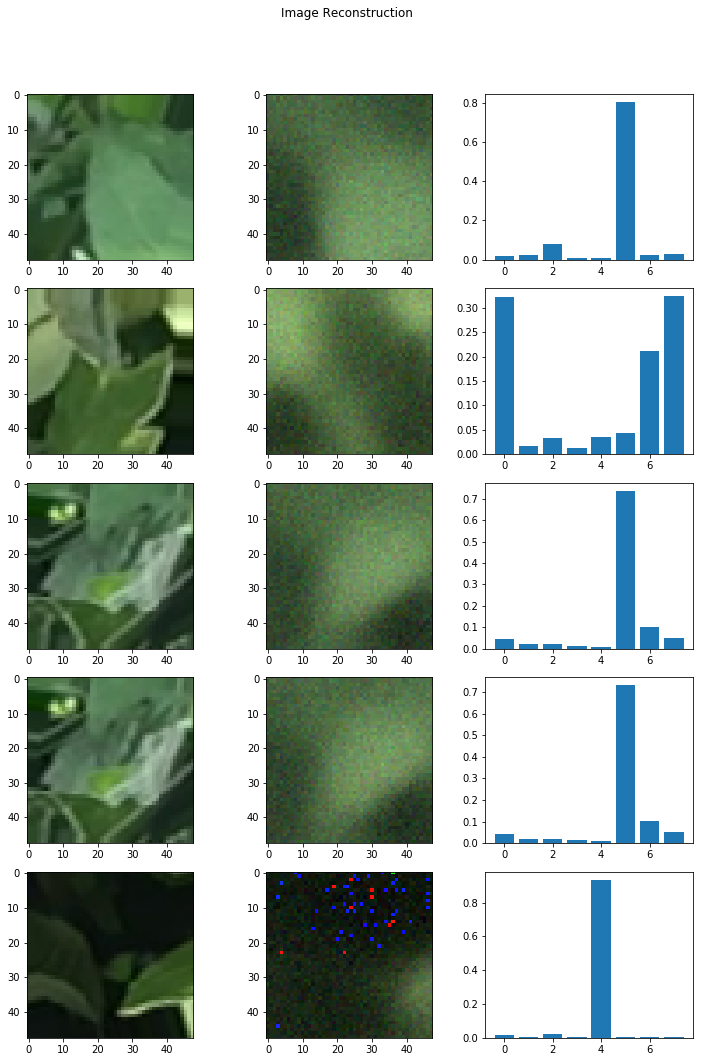

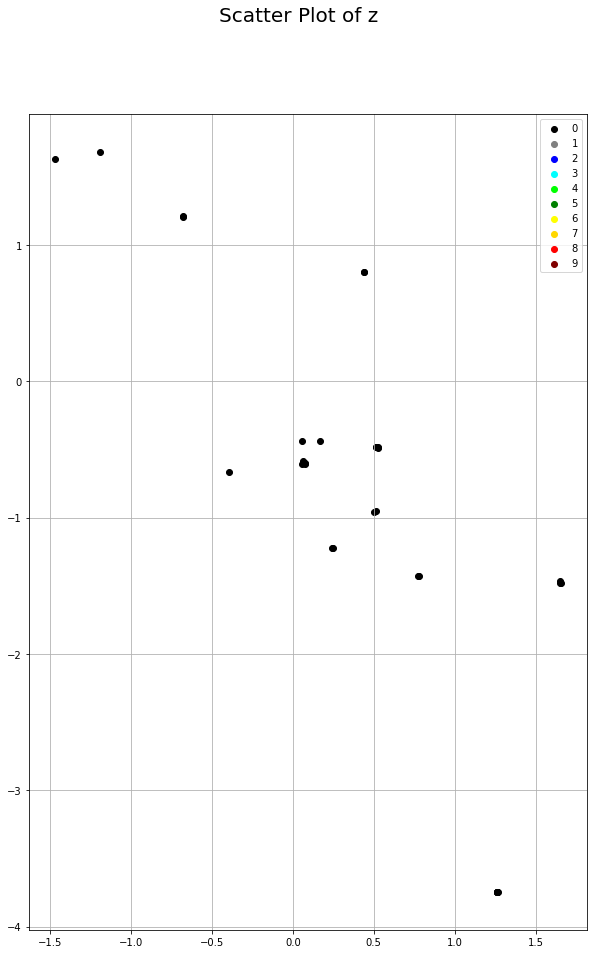

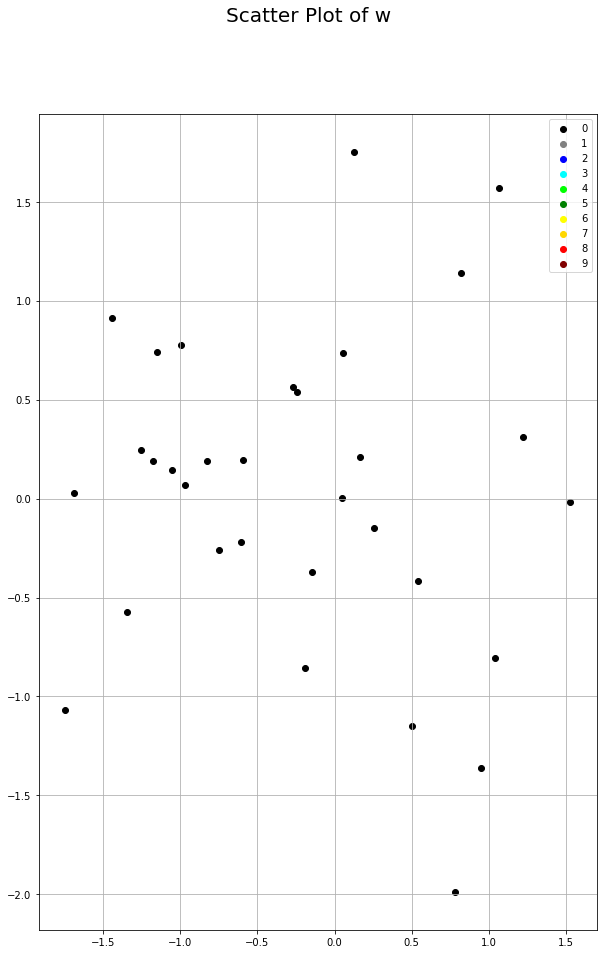

In [20]:
from GMVAE_visualize import GMVAEVisualize
visualize = GMVAEVisualize('GMVAE', results_dir, (10, 15))

data_test, _ = generate_real_samples(dataset, 32)
x_samples, z_samples, w_samples = vae_model.generate_samples(data_test, num_batches=2)    
visualize.samples(x_samples, z_samples, w_samples)
    
x_input, x_labels, x_recons, z_recons, w_recons, y_recons = vae_model.reconstruct_input(data_test)
visualize.recons(x_input, x_labels, x_recons, z_recons, w_recons, y_recons)